In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import pyfolio as pf
from zipline.api import (
    order,
    record,
    symbol,
    get_datetime,
    order_target,
    order_target_percent,
    order_target_value,
    set_benchmark,
    get_open_orders,
    set_slippage,
    set_commission,
)
from zipline import run_algorithm
from zipline.data import bundles
from zipline.utils.calendar_utils import get_calendar
import matplotlib.pyplot as plt
import seaborn as sns
from zipline.utils.calendar_utils import register_calendar, get_calendar
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.data.bundles import register, unregister, ingest
from multiprocessing import Pool
from zipline.utils.calendar_utils import get_calendar
from zipline.data.data_portal import DataPortal
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.finance.commission import PerShare, PerTrade, PerDollar
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage
import yfinance as yf
import quantstats as qs
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from scipy import stats
from zipline import run_algorithm
import warnings
import os

# Ignore warnings to maintain a clean output
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Load Zipline extensions for custom functionality
load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)


In [2]:
# Explanation: This section defines functions to calculate and visualize rolling statistics for a given return series.
# The rolling Sharpe ratio, rolling volatility, and portfolio value are calculated and plotted for analysis.

def rolling_sharpe(ret):
    """
    Calculate the rolling Sharpe ratio of a return series.

    Args:
        ret (pd.Series): Time series of returns.

    Returns:
        float: Rolling Sharpe ratio.
    """
    return np.multiply(np.divide(ret.mean(), ret.std()), np.sqrt(252))

def get_rolling_stats(result, r_window):
    """
    Calculate rolling statistics including rolling Sharpe ratio, rolling volatility, and mean portfolio value.

    Args:
        result (pd.DataFrame): DataFrame containing portfolio values.
        r_window (int): Rolling window size.

    Returns:
        pd.DataFrame: Original DataFrame with additional columns for rolling statistics.
        list: List containing rolling mean of Sharpe ratio, mean portfolio value, and rolling mean of volatility.
    """
    result["rolling_sharpe"] = result["portfolio_value"].pct_change().rolling(r_window).apply(rolling_sharpe)
    result["rolling_vol"] = result["portfolio_value"].pct_change().rolling(r_window).std()
    stats = [result.rolling_sharpe.mean(), result.portfolio_value.mean(), result.rolling_vol.mean()]
    return result, stats

def show_rolling_stats(result, r_window):
    """
    Plot rolling Sharpe ratio, rolling volatility, and portfolio value.

    Args:
        result (pd.DataFrame): DataFrame containing portfolio values.
        r_window (int): Rolling window size.

    Returns:
        pd.DataFrame: Original DataFrame with additional columns for rolling statistics.
    """
    result, stats = get_rolling_stats(result, r_window)
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    result['rolling_sharpe'].plot(ax=ax[0], title='Rolling Sharpe Ratio')
    result['rolling_vol'].plot(ax=ax[1], title='Rolling Volatility')
    result['portfolio_value'].plot(ax=ax[2], title='Portfolio Value')
    plt.show()
    return result


In [3]:
bundle = 'multi_asset_snp100'
bundle_data = bundles.load(bundle)
sids = (1,6,9,64,67)
assets = bundle_data.asset_finder.retrieve_all(sids)
assets

[Equity(1 [ABBV]),
 Equity(6 [AMD]),
 Equity(9 [AMZN]),
 Equity(64 [META]),
 Equity(67 [MRK])]

## Bollinger Bands

A mean-reversion strategy aims to enter a trade when the price seems overextended in one direction. The upper and lower bands of the Bollinger indicator are used to gauge price extension from the mean.
So, the price getting beyond any of those outer bands shows it has moved 2 SDs away from the mean, and there is a 95% chance it may reverse.

A mean-reversion strategy that uses the Bollinger Bands goes like this:

1. A long signal is formed if the price reaches the lower band.
2. A short signal is formed if the price reaches the upper band.

In [57]:
def initialize(context):
    context.i = 0
    #set_benchmark(symbol(symb))
    context.assets = assets
    context.bollinger_window = 120 # Bollinger Bands window
    context.bollinger_dev = 2 # Number of standard deviations for Bollinger Bands
    context.max_window=120

def exec_trade(data, positions):
    for asset, target_percent in positions.items():
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)


def handle_data(context, data):
    context.i += 1
    if context.i < context.max_window:
        return
    buy_signal = False
    sell_signal = False
    
    for asset in context.assets:
        # Get historical price data
        prices = data.history(asset, 'close', context.max_window + 1, frequency='1d')
        # Calculate Bollinger Bands
        sma = prices[-context.bollinger_window:].mean()
        rolling_std = prices[-context.bollinger_window:].std()
        upper_band = sma + (context.bollinger_dev * rolling_std)
        lower_band = sma - (context.bollinger_dev * rolling_std)

        # Get the current price
        current_price = data.current(asset, 'close')
    
        open_orders = get_open_orders()
        # Check if the asset is still tradable
        if data.can_trade(asset):
            # Generate signals based on Bollinger Bands
            if current_price < lower_band:
                target_percent = 1.0  # Long position
                buy_signal = True
                
            elif current_price > upper_band:
                target_percent = -1.0  # Short position
                sell_signal = True
            
            else:
                target_percent = 0.0  # Close position
            
            # Execute the trade based on the target percent
            exec_trade(data, {asset: target_percent})
        
        # Record the values for later analysis
        record(
            price=current_price,
            lower_band=lower_band, upper_band=upper_band,
            sell_signal=sell_signal,
            buy_signal=buy_signal,
            price_hist=prices
        )

In [4]:
capital_base=10000
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp('2021-01-01')

In [58]:
result = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='multi_asset_snp100',
)

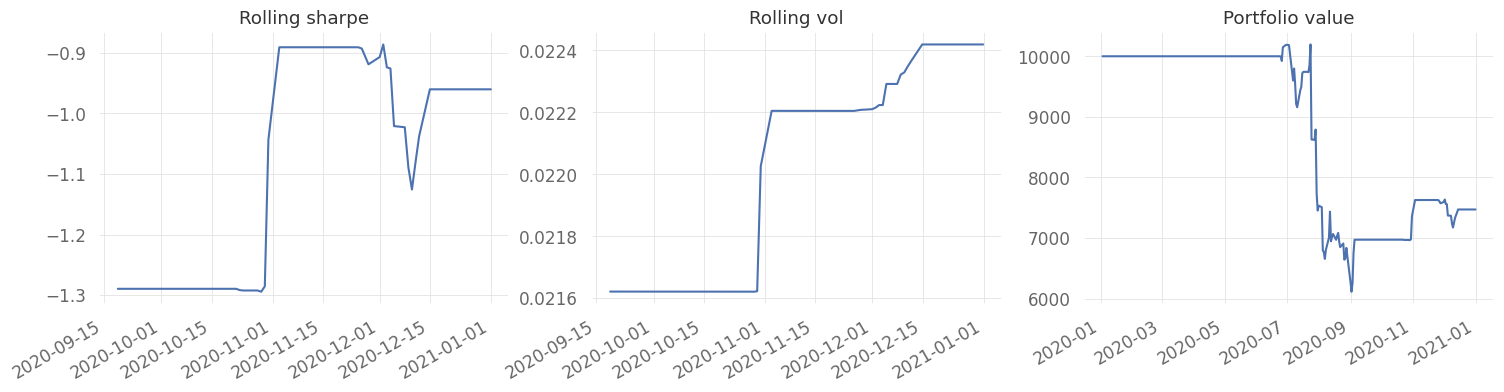

In [59]:
result = show_rolling_stats(result, 180)

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-03-03   2020-03-03
End Period                 2020-12-31   2020-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          23.22%       -77.41%
CAGR﹪                     18.97%       -70.98%

Sharpe                     0.88         -1.15
Prob. Sharpe Ratio         78.59%       12.3%
Smart Sharpe               0.8          -1.03
Sortino                    1.22         -1.35
Smart Sortino              1.1          -1.22
Sortino/√2                 0.86         -0.96
Smart Sortino/√2           0.78         -0.86
Omega                      0.77         0.77

Max Drawdown               -28.32%      -83.61%
Longest DD Days            90           303
Volatility (ann.)          35.17%       100.36%
R^2                        0.04         0.04
Information Ratio          -0.09        -0.09
Calmar    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-04,2020-10-07,2020-12-31,303,-83.605025,-83.033576


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


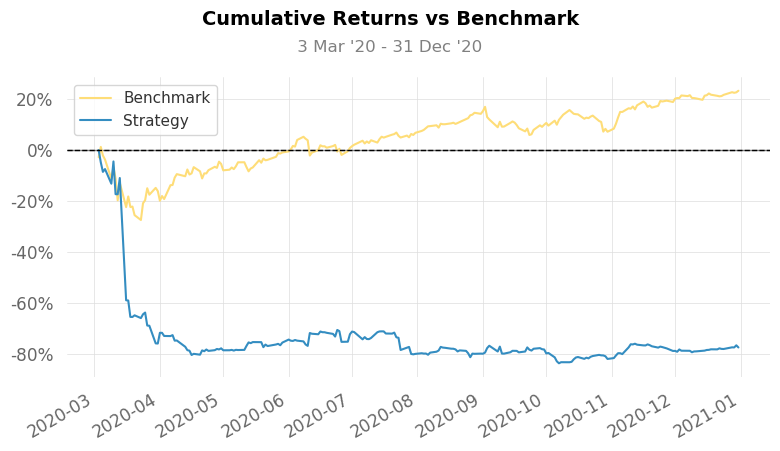

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


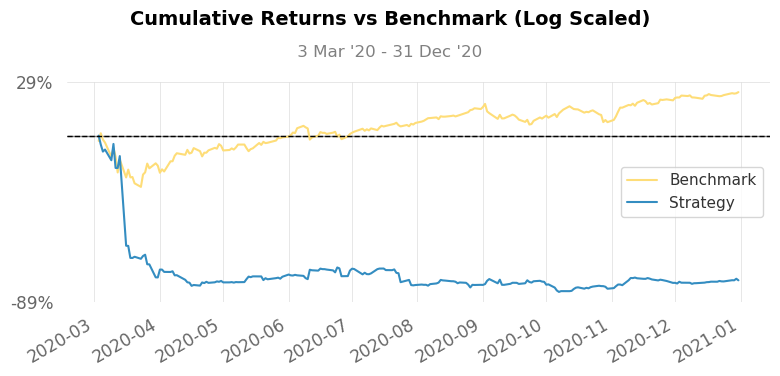

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


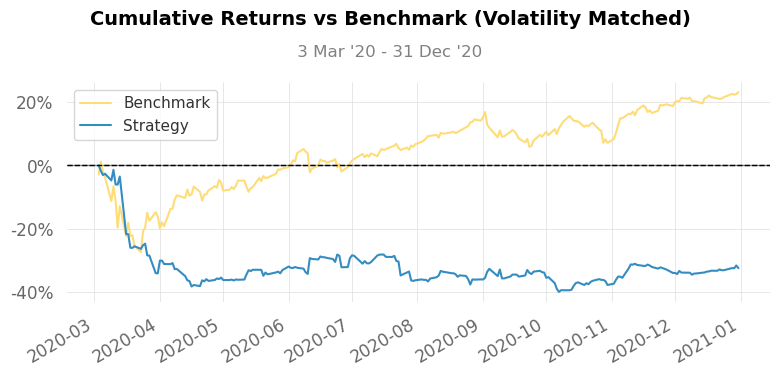

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


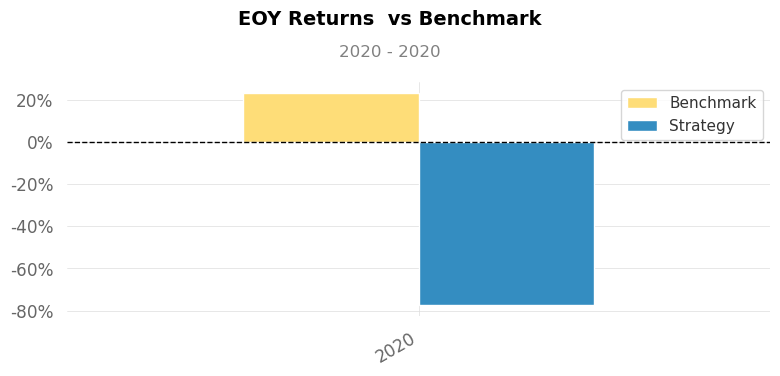

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


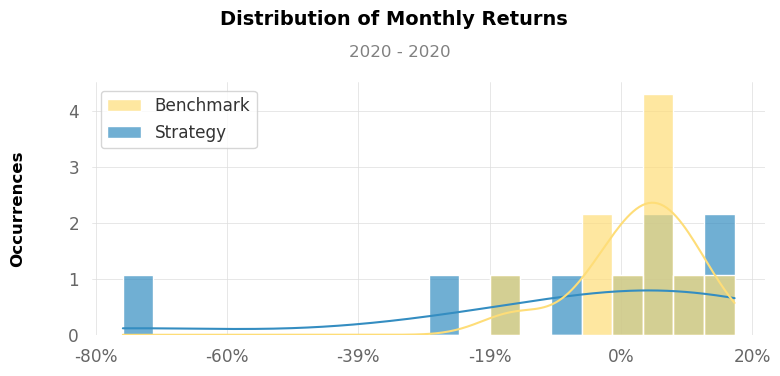

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


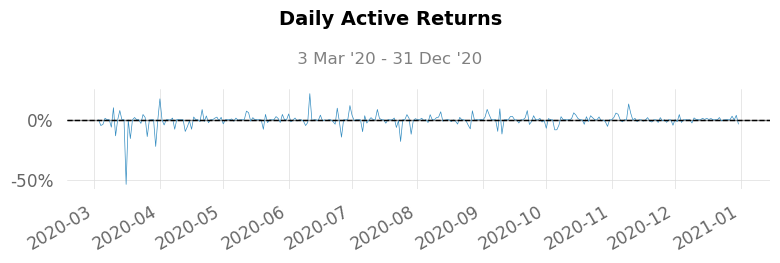

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


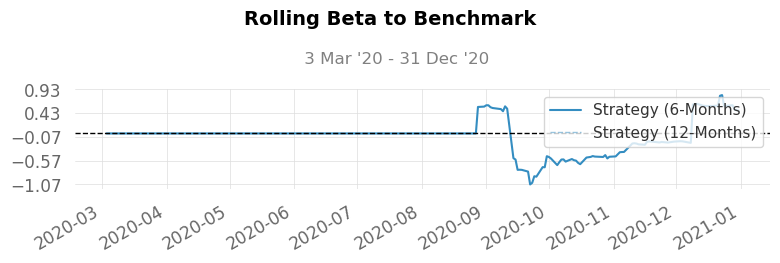

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


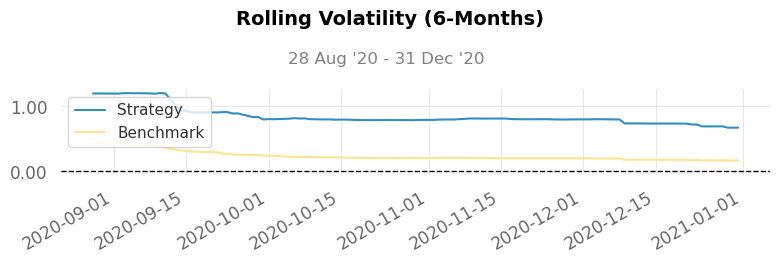

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


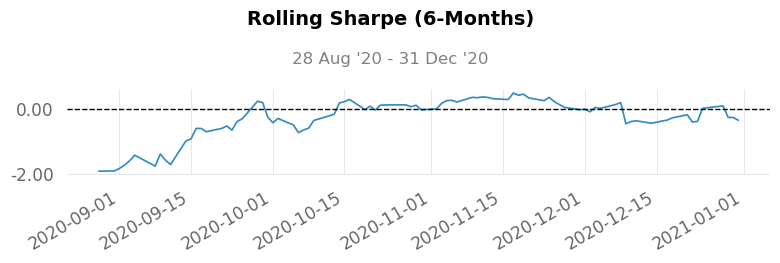

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


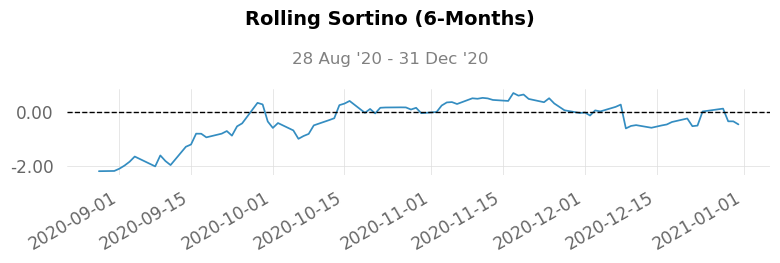

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


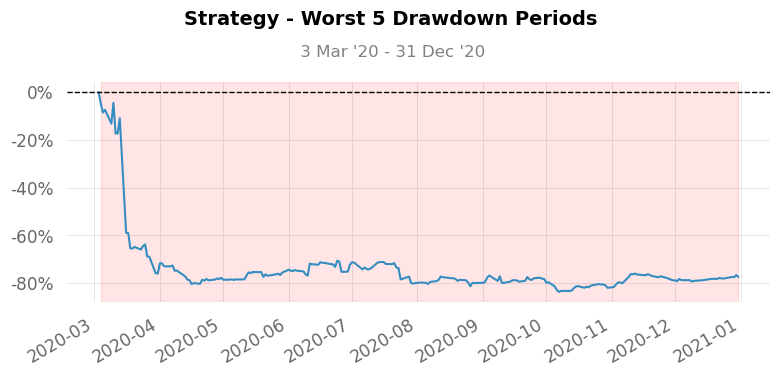

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


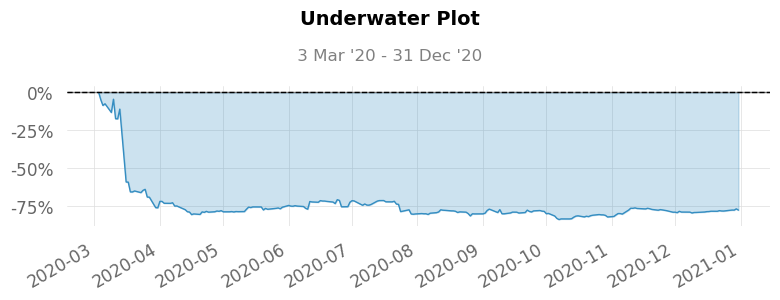

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


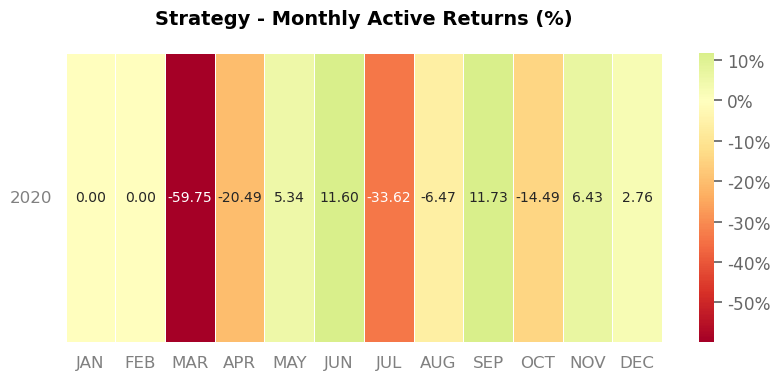

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


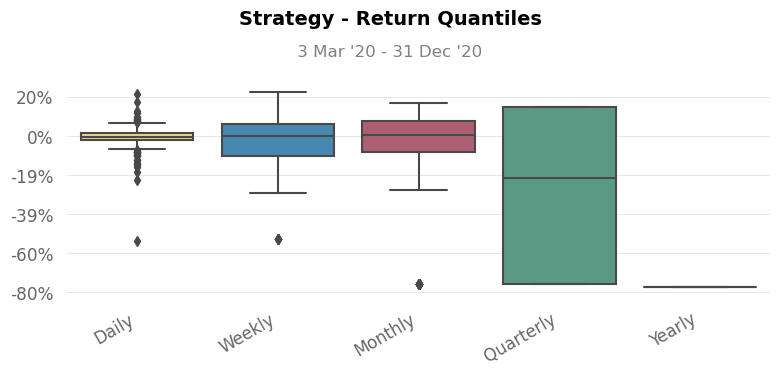

In [38]:
start = result.index[0]
end = result.index[-1]
benchmark = yf.download('SPY', start=start, end=end)['Adj Close'].pct_change()
#result.index = pd.to_datetime(result.index).tz_convert(None)
#result.index = pd.to_datetime(result.index).tz_localize('UTC').tz_convert('UTC')
# common_index = result.index.intersection(benchmark.index)
# result = result.loc[common_index]
# benchmark = benchmark.loc[common_index]
result.index = pd.to_datetime(result.index).tz_convert('UTC')
result.index = benchmark.index    
qs.reports.full(result['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4), df = result)

## Summary of the performance

The strategy had a tough time, losing -77.41% overall, while the benchmark gained 23.22%. It didn't do well annually either, with a -70.98% return compared to the benchmark's 18.97%. The strategy had more risk, as seen in its negative Sharpe ratio (-1.15) versus the benchmark's positive 0.88. The worst part was the huge Max Drawdown of -83.61%, indicating higher risk and volatility than the benchmark's -28.32%. Overall, the strategy faced challenges and didn't perform as well as the benchmark.

## Bollinger Bands + MACD

A mean-reversion strategy aims to enter a trade when the price seems overextended in one direction. The upper and lower bands of the Bollinger indicator are used to gauge price extension from the mean. 

So, the price getting beyond any of those outer bands shows it has moved 2 SDs away from the mean, and there is a 95% chance it may reverse. When we combine this with the traditional MACD signal or MACD divergence, it increases the odds of success.

A mean-reversion strategy that combines the MACD and Bollinger Bands goes like this:

1. A long signal is formed if the price reaches the lower band and reverses while the MACD makes a bullish divergence.
2. A short signal is formed if the price reaches the upper band and reverses while the MACD makes a bearish divergence.

In [5]:
capital_base = 10_000
bollinger_window = 25
bollinger_dev = 1.5
macd_short_window = 8
macd_long_window = 26
macd_signal_window = 7
max_window=max(bollinger_window,macd_long_window)

In [115]:
def initialize(context):
    context.i = 0
    #set_benchmark(symbol(symb))
    context.assets = assets
    context.bollinger_window = 15  # Bollinger Bands window
    context.bollinger_dev = 2 # Number of standard deviations for Bollinger Bands
    context.macd_short_window = 5
    context.macd_long_window = 30
    context.macd_signal_window = 15
    context.max_window=30

def exec_trade(data, positions):
    for asset, target_percent in positions.items():
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

def calculate_macd(prices, short_window, long_window, signal_window):
    exp12 = prices.ewm(span=short_window, adjust=False).mean()
    exp26 = prices.ewm(span=long_window, adjust=False).mean()
    macd = exp12 - exp26
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

def handle_data(context, data):
    context.i += 1
    if context.i < context.max_window:
        return
    buy_signal = False
    sell_signal = False
    
    for asset in context.assets:
        # Get historical price data
        prices = data.history(asset, 'close', context.max_window + 1, frequency='1d')
        # Calculate Bollinger Bands
        sma = prices[-context.bollinger_window:].mean()
        rolling_std = prices[-context.bollinger_window:].std()
        upper_band = sma + (context.bollinger_dev * rolling_std)
        lower_band = sma - (context.bollinger_dev * rolling_std)

        # Calculate MACD
        close_prices = prices[-context.macd_long_window:]
        macd, signal = calculate_macd(close_prices, context.macd_short_window, context.macd_long_window, context.macd_signal_window)

        # Get the current price
        current_price = data.current(asset, 'close')
    
        open_orders = get_open_orders()
        # Check if the asset is still tradable
        if data.can_trade(asset):
            cash = context.portfolio.cash
            # Generate signals based on Bollinger Bands and MACD
            #and current_price < lower_band
            
            if current_price < lower_band and macd.iloc[-1] > signal.iloc[-1]:
                target_percent = 1.0  # Long position
                buy_signal = True
            elif current_price > upper_band and macd.iloc[-1] < signal.iloc[-1]:
                target_percent = -1.0  # Short position
                sell_signal = True
            
            else:
                target_percent = 0.0   # Close position
            exec_trade(data, {asset: target_percent})
        
        # Record the values for later analysis
        #record(price=current_price, upper=upper_band, lower=lower_band, macd=macd.iloc[-1], signal=signal.iloc[-1])
        record(
            price=current_price,
            lower_band=lower_band, upper_band=upper_band,
            sell_signal=sell_signal,
            buy_signal=buy_signal,
            price_hist=prices
        )


In [116]:
result = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='multi_asset_snp100',
)

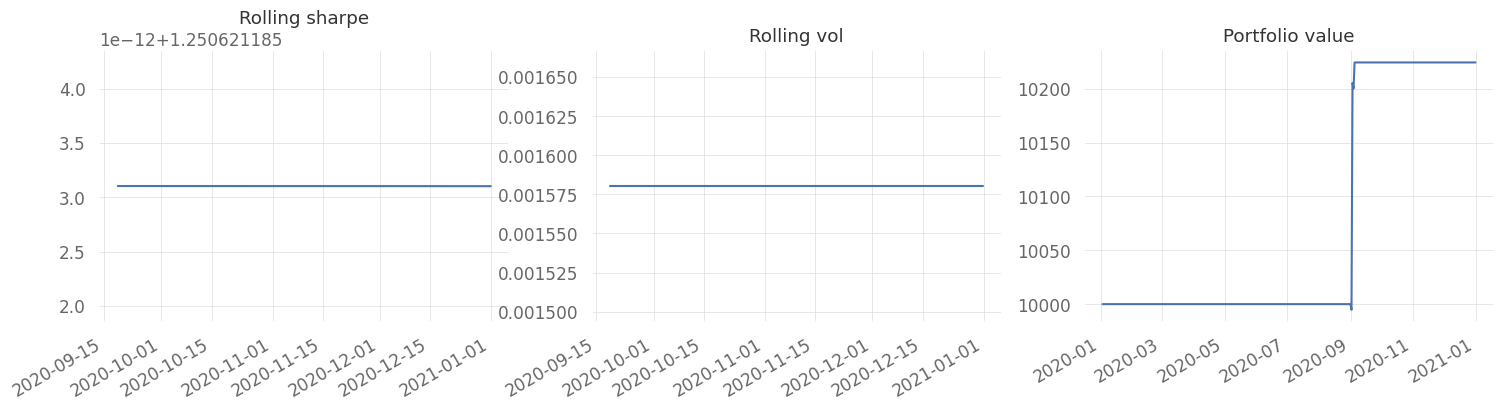

In [117]:
result = show_rolling_stats(result, 180)

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-09-01   2020-09-01
End Period                 2020-12-31   2020-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       5.0%

Cumulative Return          7.92%        2.24%
CAGR﹪                     17.2%        4.73%

Sharpe                     1.31         1.82
Prob. Sharpe Ratio         76.95%       98.55%
Smart Sharpe               1.23         1.71
Sortino                    1.83         53.41
Smart Sortino              1.72         50.08
Sortino/√2                 1.3          37.76
Smart Sortino/√2           1.21         35.41
Omega                      22.94        22.94

Max Drawdown               -9.44%       -0.05%
Longest DD Days            69           1
Volatility (ann.)          18.52%       3.65%
R^2                        0.02         0.02
Information Ratio          -0.06        -0.06
Calmar               

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-09-03,2020-09-03,2020-09-03,1,-0.050364,NaN


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


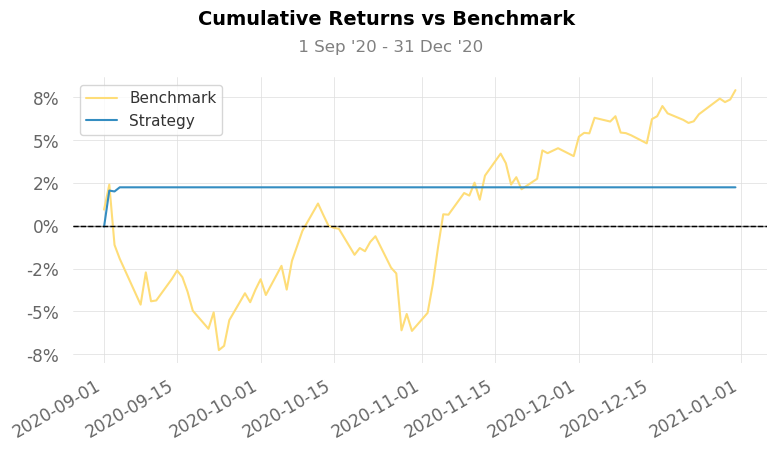

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


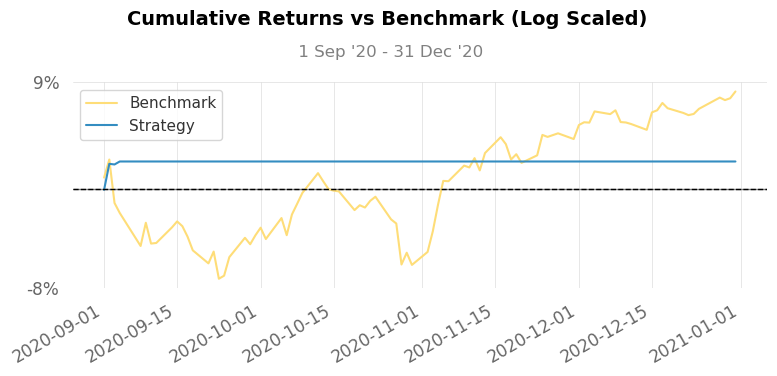

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


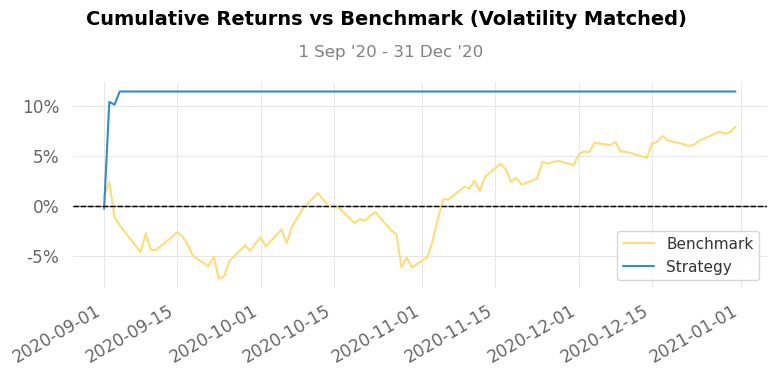

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


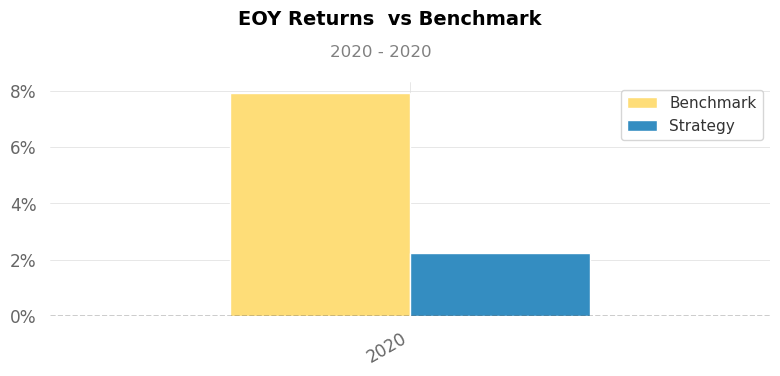

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


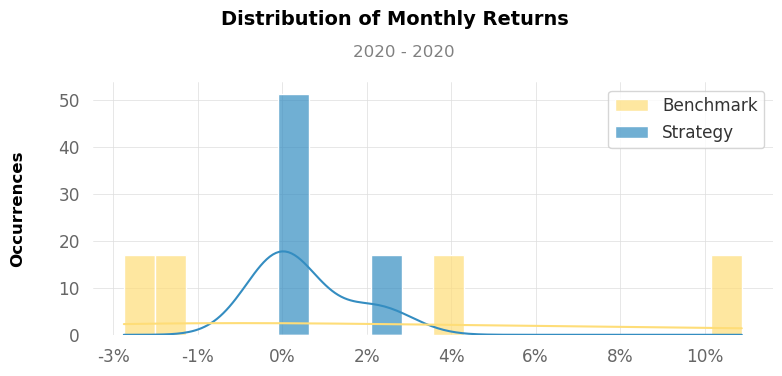

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


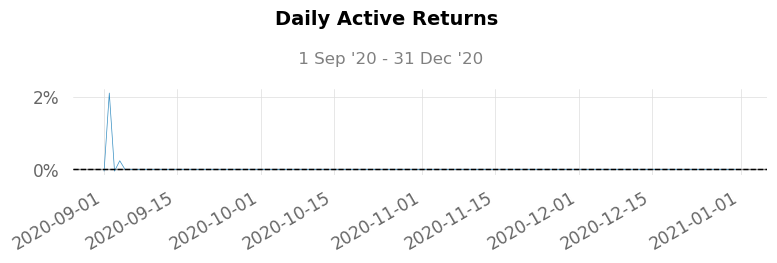

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


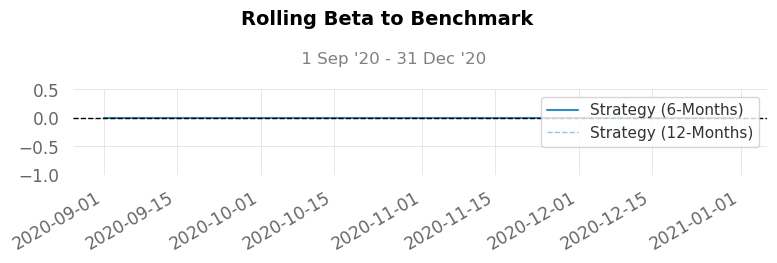

IndexError: index 0 is out of bounds for axis 0 with size 0

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


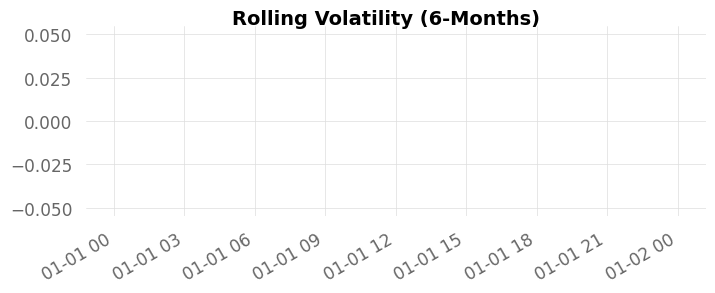

In [118]:
end = result.index[-1]
# benchmark = yf.download('SPY', start=start, end=end)['Adj Close'].pct_change()
result.index = pd.to_datetime(result.index).tz_convert(None)
result.index = benchmark.index    
qs.reports.full(result['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4), df = result)

## Summary of the performance

----------------------------------------------------------------------------------------------------------------------------------
The strategy didn't make as much money as the benchmark, with a Cumulative Return of 2.24% compared to the benchmark's 7.92%. The yearly average return (CAGR) for the strategy is 4.73%, showing decent performance over time. Despite lower total returns, the strategy handled risks well, boasting a Sharpe ratio of 1.82, which is better than the benchmark's 1.31. Importantly, the strategy's Max Drawdown was impressively low at -0.05%, indicating it held up better in tough market situations than the benchmark, which experienced a -9.44% drawdown. While it didn't win the total return game, the strategy's focus on risk control makes it appealing for investors who prioritize preserving their capital and managing risks effectively.

In [ ]:
# # start = result.index[0]
# # end = result.index[-1]
# # benchmark = yf.download('SPY', start=start, end=end)['Adj Close'].pct_change()
# result.index = pd.to_datetime(result.index).tz_convert(None)
# result.index = pd.to_datetime(result.index).tz_localize('UTC').tz_convert('UTC')
# common_index = result.index.intersection(benchmark.index)
# result = result.loc[common_index]
# benchmark = benchmark.loc[common_index]
# # # result.index = pd.to_datetime(result.index).tz_convert('UTC')
# # # result.index = benchmark.index    
# qs.reports.full(result['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4), df = result)